# Pipeline B- Z score

In [7]:
# for preprocessing/eda models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

# feature selection
from sklearn.feature_selection import RFE

# balancing
from imblearn.over_sampling import SMOTE

# accuracy metrics and data split models
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 500) # display max 500 rows

In [8]:
# read in data, make a copy, and display first 5 rows
data = pd.read_csv('online_shoppers_intention-2.csv')
data1 = data.copy()
data1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Imputation

In [9]:
# impute our assumption (beccomes a new feature)
data1['ExitRatesImpute'] = data1['ExitRates'].replace(0,np.NaN)
data1['ExitRatesImpute'] = data1['ExitRatesImpute'].fillna(data1['ExitRatesImpute'].median())

## Feature Engineering (Ratios, aggregation)

- calculate ratios for count of page visits
- combine bounce and exit rates (average and weighted average - new features)
    - they have a strong linear relationship
- divide features that have strong non-linear relationship
    - solve zero-division by replacing it with 0 (e.g. 1/0 = n/a)

In [10]:
# ratios for counts
data1['totalFracAdmin'] = data1['Administrative']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracInfo'] = data1['Informational']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracProd'] = data1['ProductRelated']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])

# average combining
data1['BounceExitAvg'] = (data1['BounceRates'] + data1['ExitRates'])/2

# weighted-average feature joining
data1['BounceExitW1'] = data1['BounceRates'] * 0.6 + data1['ExitRates'] * 0.4
data1['BounceExitW2'] = data1['BounceRates'] * 0.7 + data1['ExitRates'] * 0.3
data1['BounceExitW3'] = data1['BounceRates'] * 0.4 + data1['ExitRates'] * 0.6
data1['BounceExitW4'] = data1['BounceRates'] * 0.3 + data1['ExitRates'] * 0.7

# bounce and exit rates vs page values ratio 
data1['BouncePageRatio'] = data1['BounceRates']/data1['PageValues']
data1['ExitPageRatio'] = data1['ExitRates']/data1['PageValues']

# durations vs page values, bounce and exit rates
data1['InfoPageRatio'] = data1['Informational_Duration']/data1['PageValues']
data1['ProdRelPageRatio'] = data1['ProductRelated_Duration']/data1['PageValues']
data1['InfoBounceRatio'] = data1['Informational_Duration']/data1['BounceRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['BounceRates']
data1['ProdRelBounceRatio'] = data1['ProductRelated_Duration']/data1['BounceRates']
data1['InfoExitRatio'] = data1['Informational_Duration']/data1['ExitRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['ExitRates']
data1['ProdRelExitRatio'] = data1['ProductRelated_Duration']/data1['ExitRates']

# as there are many zero values --> e.g. x/0 (zero-division) = N/A or inf can occur 
# if there is zero-division treat that as a zero
data1 = data1.fillna(0) # fill N/A with 0 
data1 = data1.replace(np.inf, 0) # replace inf wit 0
data1 = data1.replace(-0, 0) # for some reason we also get -0 just fix it to 0 

In [11]:
print('Original number of features: ', len(data.columns))
print('Number of features added: ', len(data1.columns) - len(data.columns))
print('Total number of features after feature engineering: ', len(data1.columns) + len(data.columns))

Original number of features:  18
Number of features added:  18
Total number of features after feature engineering:  54


### Normalization
- Normalize continous values
- Requirement: -0.5 < .skew() < 0.5
- Yeo-Johnson: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html

In [12]:
# make a copy and select continous features
normalization_df = data1.select_dtypes(include='float64').drop('SpecialDay', axis = 1)
print('Nbr of continous features: ',len(normalization_df.columns))

Nbr of continous features:  24


### Features that need to be Normalized

In [13]:
# find skewed features 
normalization_needed = [] # empty list for cols that need normalizing 
normalization_df_cols = normalization_df.columns
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    else:
        ""

Right skew:  Administrative_Duration 5.61571901877419
Right skew:  Informational_Duration 7.579184715734214
Right skew:  ProductRelated_Duration 7.263227682561322
Right skew:  BounceRates 2.9478552666955347
Right skew:  ExitRates 2.1487889999009804
Right skew:  PageValues 6.382964248998132
Right skew:  ExitRatesImpute 2.1562028822830093
Right skew:  totalFracAdmin 2.6021648114344162
Right skew:  totalFracInfo 8.71792989818395
Left skew:  totalFracProd -2.4188748873082173
Right skew:  BounceExitAvg 2.6586458534384354
Right skew:  BounceExitW1 2.743271401639333
Right skew:  BounceExitW2 2.8163076932534996
Right skew:  BounceExitW3 2.5647785438589445
Right skew:  BounceExitW4 2.464233318031184
Right skew:  BouncePageRatio 41.789401807713496
Right skew:  ExitPageRatio 43.58182013321295
Right skew:  InfoPageRatio 29.69395455544613
Right skew:  ProdRelPageRatio 60.84760812139591
Right skew:  InfoBounceRatio 39.34857828293346
Right skew:  AdminBounceRatio 70.91864606229707
Right skew:  ProdRe

In [14]:
print(len(normalization_needed),' features need normalizing')

24  features need normalizing


### Plot Distribution
- Some are highly skewed and might not be possible to normalize

In [15]:
# Histogram with Normal distribution
# source: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def plot_hist(df, column, bin_amount=25):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(df[column])

    # Plot the histogram.
    ## Set the alpha value used for blending (how transparent the color is)
    plt.hist(df[column], bins=bin_amount, density=True, alpha=0.8, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.xlabel(column)
    plt.title(title)
    plt.show()

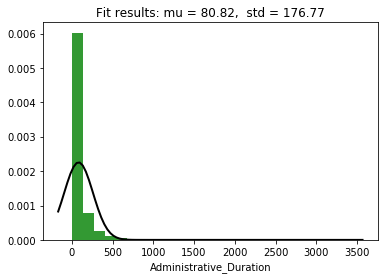

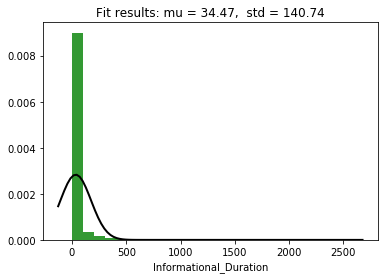

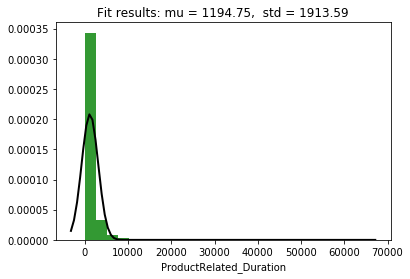

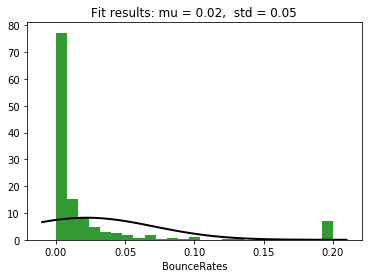

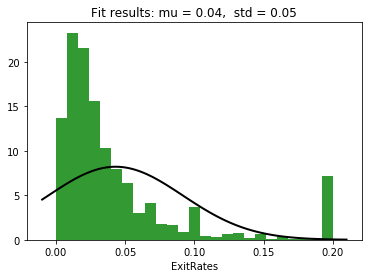

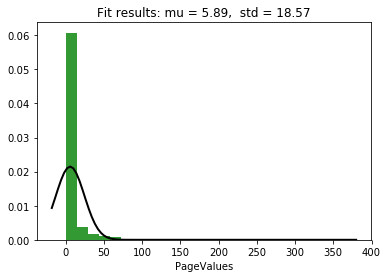

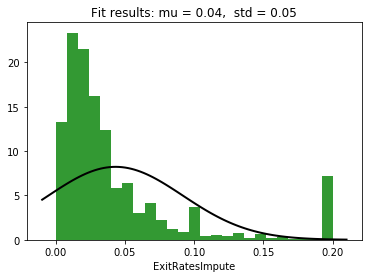

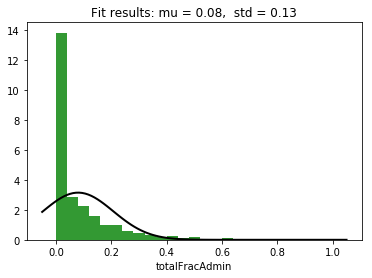

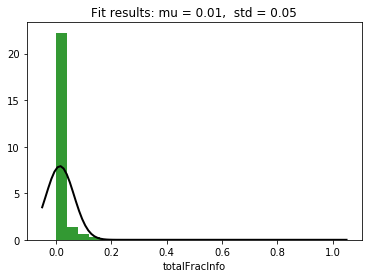

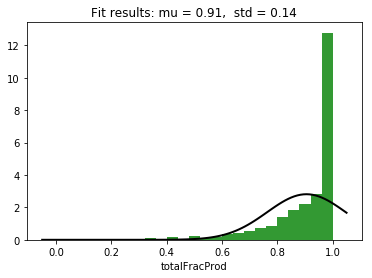

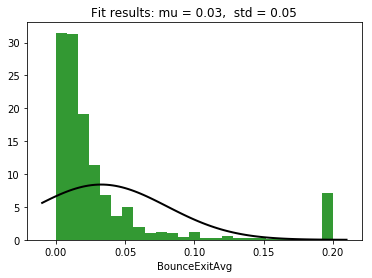

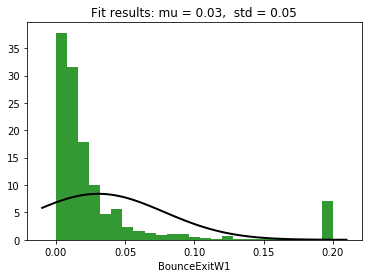

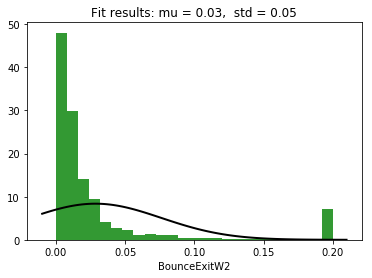

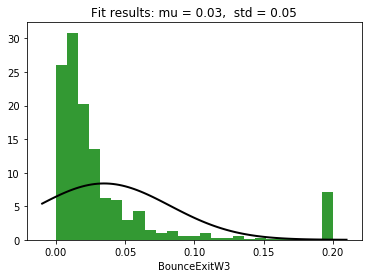

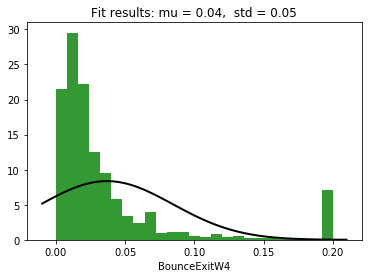

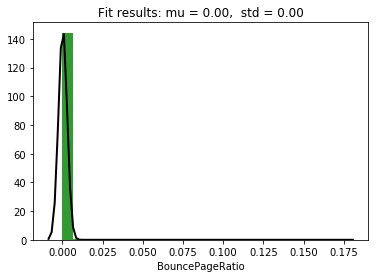

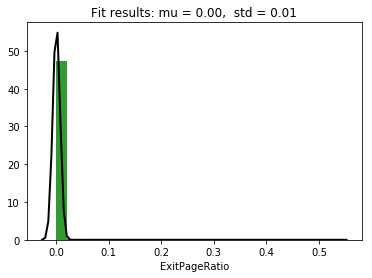

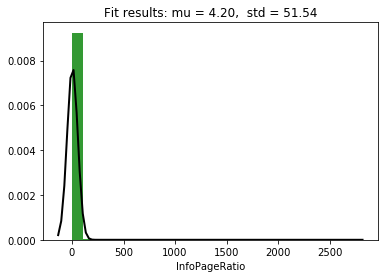

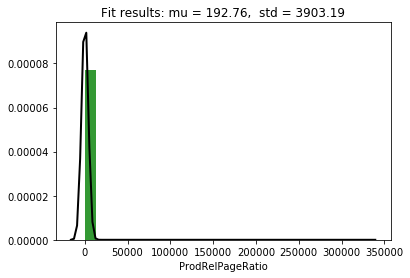

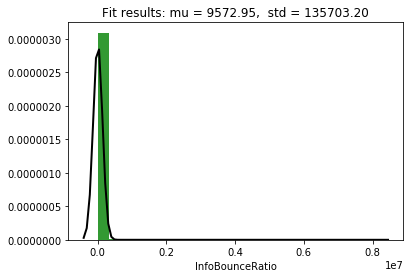

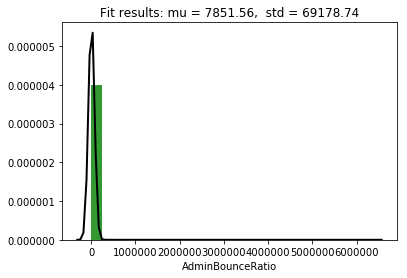

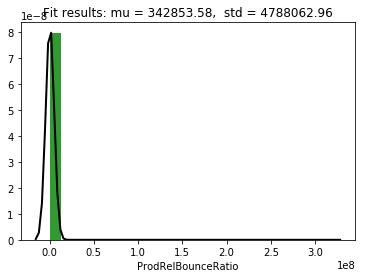

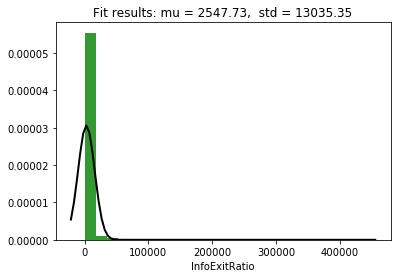

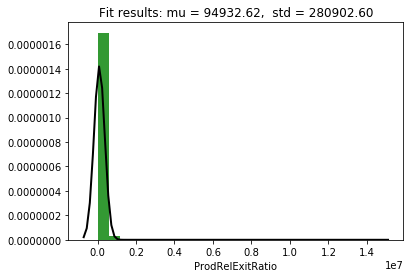

In [16]:
for col in normalization_df_cols:
    plot_hist(normalization_df, col)

### Applying Normalization

In [17]:
# innitial yeo-johnson normalization
for col in normalization_needed:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = stats.yeojohnson(normalization_df[col])[0]
    
# replace -0 with 0 
normalization_df = normalization_df.replace(-0, 0)

# square-root transformation for positively/rightly skewed features that still have a skew > 0.5 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = np.sqrt(normalization_df[col])
        
# left skew transformation
normalization_df['totalFracProd'] = normalization_df['totalFracProd']**2

# right manual transformation
normalization_df['AdminBounceRatio'] = np.sqrt(normalization_df['AdminBounceRatio'])
normalization_df['ProdRelBounceRatio'] = np.sqrt(np.sqrt(normalization_df['ProdRelBounceRatio']))

### Skew after normalization

In [18]:
not_normalized = []
# if still not normal display 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    else:
         print('Normalized', col,normalization_df[col].skew())

Normalized Administrative_Duration 0.14548485903583394
Right skew:  Informational_Duration 1.541621552467758
Normalized ProductRelated_Duration -0.03633623414663036
Normalized BounceRates 0.39101532666328925
Normalized ExitRates 0.43359787791682225
Right skew:  PageValues 1.3568274787103407
Normalized ExitRatesImpute 0.441083931830612
Normalized totalFracAdmin 0.15463883173278434
Right skew:  totalFracInfo 1.4670525404458559
Left skew:  totalFracProd -1.5358710010478271
Normalized BounceExitAvg -0.021538423564108185
Normalized BounceExitW1 0.05696128765268017
Normalized BounceExitW2 0.15363549856656428
Normalized BounceExitW3 -0.08607076986162765
Normalized BounceExitW4 -0.1397448987361812
Right skew:  BouncePageRatio 2.4707035939661797
Right skew:  ExitPageRatio 1.697544739068237
Right skew:  InfoPageRatio 3.057008436296968
Right skew:  ProdRelPageRatio 1.3505084216126444
Right skew:  InfoBounceRatio 2.171048860562673
Normalized AdminBounceRatio -0.03222113937735709
Normalized ProdRel

In [19]:
print('Number of features that were not normalized: ',len(not_normalized))
print('Number of features that were normalized: ', len(normalization_needed) - len(not_normalized))

Number of features that were not normalized:  10
Number of features that were normalized:  14


### Checking distribution of features 10 features not fully normalized 
- they look almost binary (contain a lot of zero-values) 
- we will create new features by binning them on some threshold (e.g. zero or not)

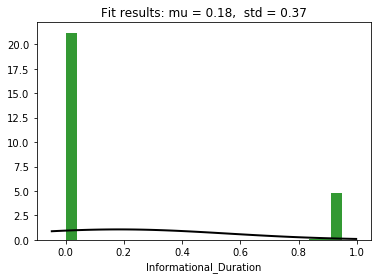

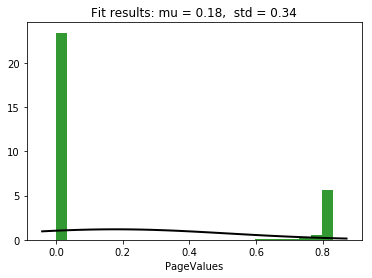

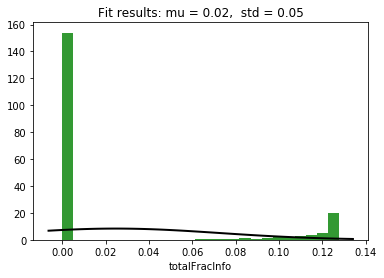

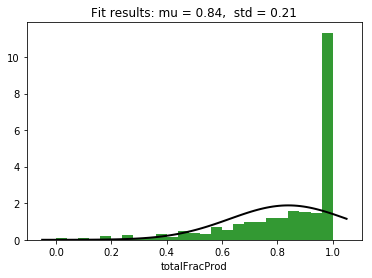

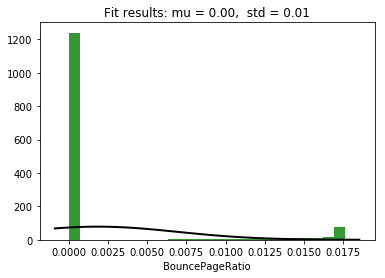

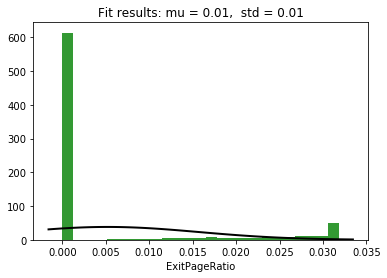

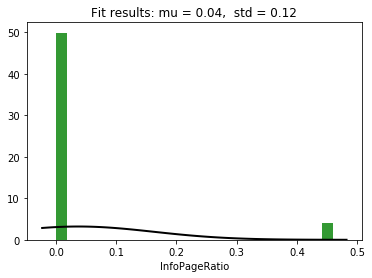

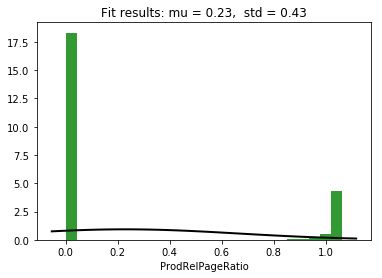

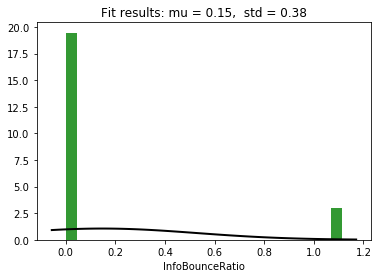

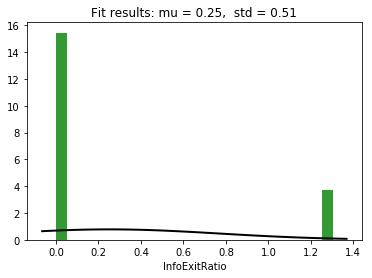

In [20]:
for col in not_normalized:
    plot_hist(normalization_df, col)

### Most frequent values for not fully normalized features

- are moslty zeroes so we will bin them depending on whether the value is a zero or not
- more zeroes occur in ratios as zero-division can be encountered
- left skew is moslty 1 (we will bin it if >=0.4 is 1 else 0 based on histogram)

In [21]:
for col in not_normalized:
    print(col, '\n',normalization_df[col].value_counts().head(1))

Informational_Duration 
 0.0    9925
Name: Informational_Duration, dtype: int64
PageValues 
 0.0    9600
Name: PageValues, dtype: int64
totalFracInfo 
 0.0    9699
Name: totalFracInfo, dtype: int64
totalFracProd 
 1.0    5299
Name: totalFracProd, dtype: int64
BouncePageRatio 
 0.0    10792
Name: BouncePageRatio, dtype: int64
ExitPageRatio 
 0.0    9637
Name: ExitPageRatio, dtype: int64
InfoPageRatio 
 0.0    11315
Name: InfoPageRatio, dtype: int64
ProdRelPageRatio 
 0.0    9600
Name: ProdRelPageRatio, dtype: int64
InfoBounceRatio 
 0.0    10699
Name: InfoBounceRatio, dtype: int64
InfoExitRatio 
 0.0    9932
Name: InfoExitRatio, dtype: int64


### Add suffix and merge with Data1
- add suffix to columns that needed normalization even the ones that could not be fully normalized

In [22]:
for col in normalization_needed: # All needed normalization 
    normalization_done = normalization_df.add_suffix('_Norm') # add suffix to distinguish 

In [23]:
# concat normalized features with scaled and original
data1 = pd.concat([data1,normalization_done], axis = 1)

In [24]:
# we now have 60 columns 
data1.shape

(12330, 60)

### Standardization (Z-score/StandardScaler)

In [25]:
# take the continous normalized columns columns 
standardize = data1[normalization_done.columns]

In [26]:
# import StandardScaler module
from sklearn.preprocessing import StandardScaler

# Instantiate
scaler = StandardScaler()
# Fit and transform, convert to DF
standardize_scaled = scaler.fit_transform(standardize)
standardize_done = pd.DataFrame(standardize_scaled, columns=standardize.columns)
standardize_done = standardize_done.add_suffix('_Scaled') # add suffix (new features)

# Concatenate categoric columns to scaled numeric columns
data1 = pd.concat([data1, standardize_done], axis=1)

# check features are scaled
pd.set_option('float_format', '{:f}'.format)
standardize_done.describe()

,Administrative_Duration_Norm_Scaled,Informational_Duration_Norm_Scaled,ProductRelated_Duration_Norm_Scaled,BounceRates_Norm_Scaled,ExitRates_Norm_Scaled,PageValues_Norm_Scaled,ExitRatesImpute_Norm_Scaled,totalFracAdmin_Norm_Scaled,totalFracInfo_Norm_Scaled,totalFracProd_Norm_Scaled,BounceExitAvg_Norm_Scaled,BounceExitW1_Norm_Scaled,BounceExitW2_Norm_Scaled,BounceExitW3_Norm_Scaled,BounceExitW4_Norm_Scaled,BouncePageRatio_Norm_Scaled,ExitPageRatio_Norm_Scaled,InfoPageRatio_Norm_Scaled,ProdRelPageRatio_Norm_Scaled,InfoBounceRatio_Norm_Scaled,AdminBounceRatio_Norm_Scaled,ProdRelBounceRatio_Norm_Scaled,InfoExitRatio_Norm_Scaled,ProdRelExitRatio_Norm_Scaled
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
std,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041,1.000041
min,-0.996659,-0.492101,-2.096783,-0.974179,-1.785861,-0.531818,-1.807501,-1.005365,-0.515133,-3.959314,-2.771318,-2.620629,-2.427209,-2.891764,-2.989581,-0.366273,-0.496257,-0.298863,-0.532522,-0.390440,-1.029711,-0.986837,-0.491352,-2.077588
25%,-0.996659,-0.492101,-0.624266,-0.974179,-0.768540,-0.531818,-0.786644,-1.005365,-0.515133,-0.466684,-0.729365,-0.731772,-0.764149,-0.713641,-0.700506,-0.366273,-0.496257,-0.298863,-0.532522,-0.390440,-1.029711,-0.986837,-0.491352,-0.624668
50%,0.052304,-0.492101,0.027929,-0.084167,-0.185516,-0.531818,-0.181172,0.065843,-0.515133,0.418548,-0.034853,-0.078062,-0.077427,-0.032535,-0.011143,-0.366273,-0.496257,-0.298863,-0.532522,-0.390440,0.614466,-0.986837,-0.491352,0.040732
75%,0.981431,-0.492101,0.654771,0.859497,0.722460,-0.531818,0.723407,1.007566,-0.515133,0.757905,0.749608,0.713822,0.754345,0.726685,0.714709,-0.366273,-0.496257,-0.298863,-0.532522,-0.390440,0.981768,1.025582,-0.491352,0.654714
max,1.995243,2.061159,5.313616,1.733188,1.982547,1.938721,1.982622,1.513971,2.155760,0.757905,1.760660,1.784062,1.808320,1.738774,1.718535,3.115470,2.544921,3.391490,1.933869,2.563640,1.564826,1.229125,2.049533,5.299718


In [27]:
print('Number of features before standardization: ', len(data1.columns) - len(standardize_done.columns))
print('Number of features added: ', len(standardize_done.columns))
print('Total number of features after standardization: ', len(data1.columns))

Number of features before standardization:  60
Number of features added:  24
Total number of features after standardization:  84


In [28]:
standardize_done.to_csv('PipelineB-Zscore.csv')